# Imports

In [186]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
%matplotlib inline

In [5]:
!ls

Titanic_Sklearn.ipynb test.csv
gender_submission.csv train.csv


In [6]:
!wc -l test.csv

     419 test.csv


In [7]:
!wc -l train.csv

     892 train.csv


In [105]:
test, train = pd.read_csv('test.csv'), pd.read_csv('train.csv')

In [10]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [11]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data Exploration

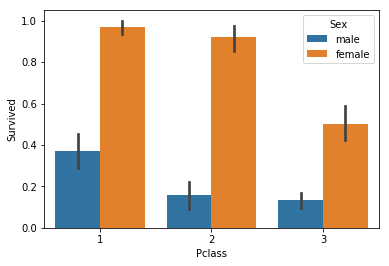

In [14]:
ax = sns.barplot(x='Pclass',y='Survived',hue='Sex',data=train)

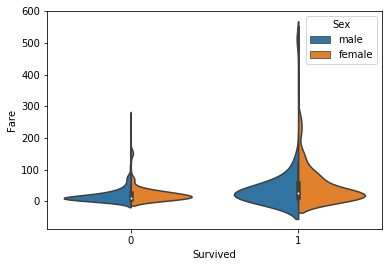

In [347]:
ax = sns.violinplot(x='Survived',y='Fare',hue='Sex',data=train,split=True)

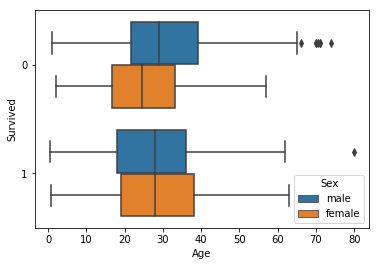

In [21]:
ax = sns.boxplot(x='Age',y='Survived',hue='Sex',data=train,orient='h')

# Preprocessing

In [22]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [317]:
def get_titles(df):
    df['Title'] = df.Name.str.extract(' ([a-zA-Z]+)\.', expand=False)
    df['Title'] = [title if title in ['Mr','Miss','Mrs','Master','Dr'] else 'Other' for title in df.Title]
    return df

def get_nicknames(df):
    df['Nickname'] = df.Name.str.extract('\(([a-zA-Z ]+)\)', expand=False)
    df['NickExists'] = df.Nickname.apply(lambda x: 0 if x is np.nan else 1)
    return df

def get_cabin_letter(df):
    df['CabinLetter'] = df.Cabin.str.extract('([A-Z])[0-9]*', expand=False)
    return df

def drop_columns(df):
    cols_to_drop = ['Name','Nickname','Ticket','Cabin','PassengerId']
    return df.drop(cols_to_drop,1)

def preprocess(train, test):
    # Feature wrangling
    train = drop_columns(get_cabin_letter(get_nicknames(get_titles(train))))
    test = drop_columns(get_cabin_letter(get_nicknames(get_titles(test))))
    # One-hot encoding for categorical variables
    combined = train.append(test, ignore_index=True)
    combined = pd.get_dummies(combined,dummy_na=True)
    # Split train and test back out
    train, test = combined.iloc[:train.shape[0]], combined.iloc[train.shape[0]:]
    train.Age.fillna(999, inplace=True)
    test.Age.fillna(999, inplace=True)
    test = test.drop('Survived', 1)
    
    return train, test

In [318]:
encoded_train, encoded_test = preprocess(train, test)

/Users/ray/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [319]:
# Split train into x_train, x_test, y_train, y_test
x_all, y_all = encoded_train[[c for c in encoded_train.columns if c!='Survived']],encoded_train['Survived']
x_train, x_test, y_train, y_test = train_test_split(x_all,y_all,train_size=.80)

/Users/ray/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [342]:
# Try different classifiers for continuous and categorical variables

import xgboost
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier

In [343]:
%%capture
xgb = xgboost.XGBClassifier()
rf = RandomForestClassifier(n_estimators=500)
nn = KNeighborsClassifier()
sgd = SGDClassifier()
perc = Perceptron()
logreg = LogisticRegression()
svc = SVC()
gnb = GaussianNB()
mlp = MLPClassifier()
xtc = ExtraTreesClassifier()

clfs = ['xgb', 'rf', 'nn', 'sgd', 'perc', 'logreg', 'svc', 'gnb', 'mlp', 'xtc']

scores = {}
for clf in clfs:
    globals()[clf].fit(x_train,y_train)
    scores[clf] = cross_val_score(globals()[clf],x_all,y_all,cv=25)

scores_df = pd.DataFrame(scores)

scores_df['id'] = scores_df.index

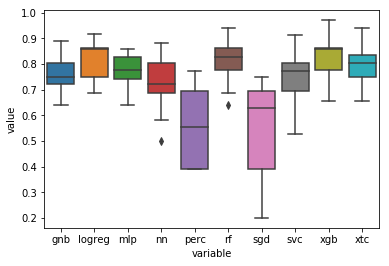

In [344]:
sns.boxplot(x='variable',y='value',data=scores_df.melt(id_vars='id'))

In [339]:
pd.Series(xgb.feature_importances_,index=x_all.columns).sort_values(ascending=False)

Fare               0.309441
Age                0.225524
SibSp              0.096154
Pclass             0.068182
Sex_female         0.055944
Title_Mr           0.052448
Title_Master       0.036713
CabinLetter_nan    0.034965
Embarked_C         0.026224
CabinLetter_C      0.026224
CabinLetter_E      0.017483
Embarked_S         0.013986
Parch              0.012238
Title_Other        0.008741
CabinLetter_D      0.008741
Title_Dr           0.005245
Title_Mrs          0.001748
CabinLetter_B      0.000000
NickExists         0.000000
Title_Miss         0.000000
CabinLetter_A      0.000000
Sex_male           0.000000
Sex_nan            0.000000
CabinLetter_F      0.000000
CabinLetter_G      0.000000
CabinLetter_T      0.000000
Embarked_Q         0.000000
Embarked_nan       0.000000
Title_nan          0.000000
dtype: float32

In [340]:
pd.Series(rf.feature_importances_,index=x_all.columns).sort_values(ascending=False)

Fare               0.210651
Age                0.201505
Title_Mr           0.088045
Sex_male           0.084142
Sex_female         0.078433
Pclass             0.068017
SibSp              0.053162
CabinLetter_nan    0.032553
Parch              0.031571
Title_Miss         0.023817
NickExists         0.018808
Title_Mrs          0.016774
Embarked_C         0.013774
Title_Master       0.013373
Embarked_S         0.012918
CabinLetter_E      0.012449
CabinLetter_C      0.008262
Embarked_Q         0.007696
CabinLetter_B      0.006084
CabinLetter_D      0.004402
Title_Other        0.004229
CabinLetter_A      0.002614
CabinLetter_F      0.002285
Title_Dr           0.002101
CabinLetter_G      0.001941
CabinLetter_T      0.000376
Embarked_nan       0.000019
Sex_nan            0.000000
Title_nan          0.000000
dtype: float64